# Visualizing the ideas of mixup

The objective of supervised learning is to find a function that adequately maps features to targets.  This is achieved by finding the function that minimizes the expected risk of misclassification.  To define the expected risk, one must specify both a loss function and a probability distribution for the data.  In practice, little is known about the distribution of the data, so the distribution is approximated by delta functions.  The resulting paradigm is known as empirical risk minimization.  In their paper "mixup: Beyond Empirical Risk Minimization," the authors critique this paradigm and offer an alternative framework they call "mixup."  In "mixup," data is generated from a "vicinal distribution."  To sample a data point from this distribution, one creates a convex combinations of two images from the original dataset.  The proportion of each image in the combination is a random variable that is drawn from a Beta distribution.  Risk minimization is performed by computing the loss of the output against each of the original labels.  The sum of these two losses is computed proportionally to the contribution of each original image to the mixed up image.

In part 1 of my report, I use the CIFAR-10 dataset to visualize the mixup distribution.  I compare it to the Gaussian vicinal distribution derived in the paper "Vicinal Risk Minimization" (Chapelle, et al) and discussed in the mixup paper.

In part 2 of my report, I put both distributions to the test on a custom ResNet-inspired network.

In [8]:
#Importing necessary libraries

import torch
from torchvision import transforms, datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import pandas as pd
from skimage.util import random_noise
import random

In [9]:
#Downloading training, validation, and test CIFAR-10 data

train_data, val_data = random_split(datasets.CIFAR10(root='./data', train=True, download=True,
                                                   transform=transforms.ToTensor()), [40000, 10000])
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [10]:
#Functions for moving tensors/models to GPU

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
#Generating dataloaders and moving training data to GPU

batch_size=128

train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_data, batch_size, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_data, batch_size, num_workers=4, pin_memory=True)

train_dl = DeviceDataLoader(train_dl, 'cuda')

### Visualizing the Gaussian Vicinal Distribution

In "Vicinal Risk Minimization", the authors introduce the Gaussian vicinal distribution.  The basic assumption behind this distribution is that for a given data point x, nearby data points should share the same class as x.  Thus, the Gaussian vicinal distribution smoothes out the empirical distribution by replacing the delta functions with Normal distributions centered at each data point.  The authors of the paper argue that the variance of each distribution should be tuned to each data point.  This "adaptive kernel width" at a point x should be a function of data points close to x.  I discuss my attempts to implement adaptive kernels in part 2.  Here, we will simply be looking at the distribution for fixed variances.  As the authors of "mixup" note, this is equivalent to augmenting the data with Guassian noise.  I utilize the function "random_noise" from the library skimage.util to add noise to each image.  First, I investigate what happens to an assortment of images when the variance is 0.01, 0.02, 0.03, and 0.04.


In [86]:
#Gathering an assortment of images and adding noise to each

gaussian_images = []
for batch in train_dl:
    images, labels = batch
    for i in range(67,70):
        gaussian_images.append(images[i])
        gaussian_images.append(torch.from_numpy(random_noise(images[i].cpu().numpy(),
                                                             mode='gaussian', mean=0, var=0.01, clip=True)))
        gaussian_images.append(torch.from_numpy(random_noise(images[i].cpu().numpy(), 
                                                             mode='gaussian', mean=0, var=0.02, clip=True)))
        gaussian_images.append(torch.from_numpy(random_noise(images[i].cpu().numpy(), 
                                                             mode='gaussian', mean=0, var=0.03, clip=True)))
        gaussian_images.append(torch.from_numpy(random_noise(images[i].cpu().numpy(),
                                                             mode='gaussian', mean=0, var=0.04, clip=True)))
    break
            
            

<Figure size 432x288 with 0 Axes>

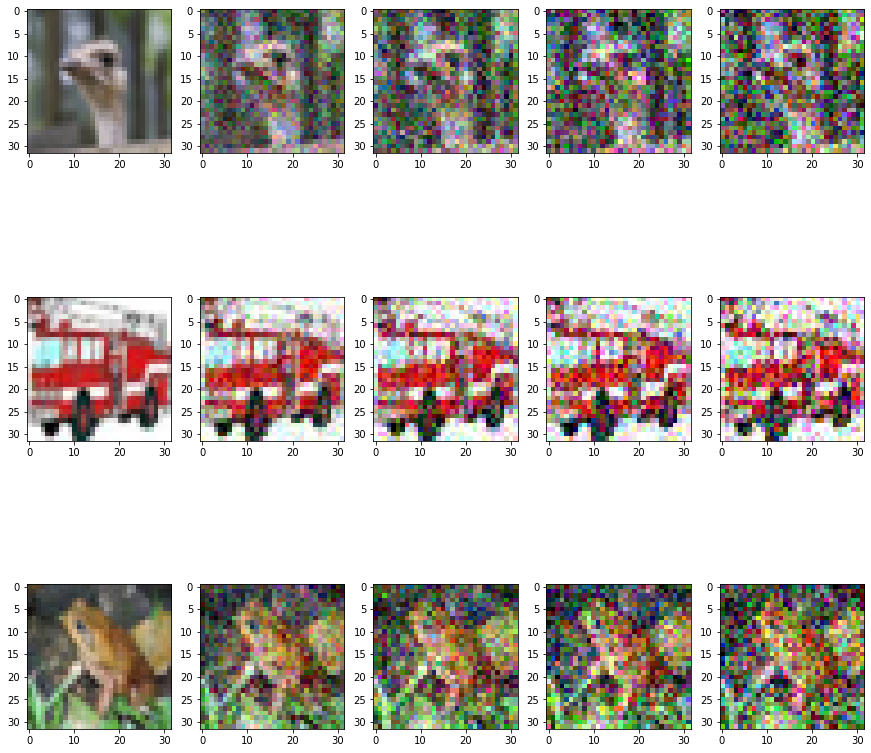

In [87]:
#Plotting original image and noisy images

plt.figure()
f, axarr = plt.subplots(3,5, figsize=(15,15)) 
axarr[0,0].imshow(gaussian_images[0].cpu().permute(1,2,0))
axarr[0,1].imshow(gaussian_images[1].cpu().permute(1,2,0))
axarr[0,2].imshow(gaussian_images[2].cpu().permute(1,2,0))
axarr[0,3].imshow(gaussian_images[3].cpu().permute(1,2,0))
axarr[0,4].imshow(gaussian_images[4].cpu().permute(1,2,0))
axarr[1,0].imshow(gaussian_images[5].cpu().permute(1,2,0))
axarr[1,1].imshow(gaussian_images[6].cpu().permute(1,2,0))
axarr[1,2].imshow(gaussian_images[7].cpu().permute(1,2,0))
axarr[1,3].imshow(gaussian_images[8].cpu().permute(1,2,0))
axarr[1,4].imshow(gaussian_images[9].cpu().permute(1,2,0))
axarr[2,0].imshow(gaussian_images[10].cpu().permute(1,2,0))
axarr[2,1].imshow(gaussian_images[11].cpu().permute(1,2,0))
axarr[2,2].imshow(gaussian_images[12].cpu().permute(1,2,0))
axarr[2,3].imshow(gaussian_images[13].cpu().permute(1,2,0))
axarr[2,4].imshow(gaussian_images[14].cpu().permute(1,2,0))
plt.show()

Above, we can see a bird, a truck, and a frog.  The leftmost images are the originals.  The results of adding noise with variance 0.01, 0.02, 0.03, and 0.04 are displayed along next to each original.  It seems that when the variance is 0.01, the images are still mostly intact, though it should be noted that the original images are already a little difficult to see as the resolution is merely 32x32.  Surprisingly, when the variance is 0.04, the images become extremely distorted.  Each color channel of each pixel takes a value between 0 and 1.  So, the variance is a mere 4% of the total range of values each channel can take.  Apparently, this is enough to make the bird in the top right corner almost unrecognizable, and the frog is barely visible as well.  Most humans would probably have a hard time classifying the images on the right.  This casts into doubt the extent to which the Gaussian vicinal distribution is appropriate for image classification.  As discussed above, the motivation for this distribution is the notion that closely related examples belong to the same class.  If the images on the right are to count as "closely related" to the original, then this assumption might be false, at least for variances that are higher than about 0.01 or 0.02.  This is an idea that I will discuss further in part 2.

Before moving on to mixup, let's look at histograms of the distances between the original images and the noisy images

In [12]:
#Creating the noisy images and calculating the distances to the original images

def get_distances(dl, variance):
    distances = []
    for batch in dl:
        images, labels = batch
        noisy_images = random_noise(images.cpu().numpy(), mode='gaussian', mean=0, var=variance, clip=True)
        dist = images - torch.from_numpy(noisy_images).cuda()
        distances.append(dist)
    distances_tens = torch.mean(torch.cat(distances), dim=(1,2,3))
    dist_arr = distances_tens.cpu().numpy()
    torch.cuda.empty_cache()
    return dist_arr

distances1 = get_distances(train_dl, 0.01)
distances2 = get_distances(train_dl, 0.02)
distances3 = get_distances(train_dl, 0.03)
distances4 = get_distances(train_dl, 0.04)



<Figure size 432x288 with 0 Axes>

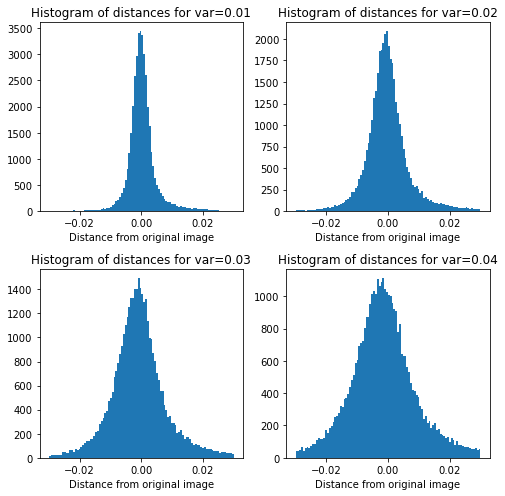

In [13]:
#Creating Histograms of the distances calculated above

distances = np.stack((distances1,distances2,distances3,distances4))
titles = ['Histogram of distances for var=0.01', 'Histogram of distances for var=0.02', 
          'Histogram of distances for var=0.03', 'Histogram of distances for var=0.04']
plt.figure()


f, axarr = plt.subplots(2,2, figsize=(7,7)) 
a = axarr.ravel()
for idx,ax in enumerate(a):
    ax.hist(distances[idx,:], bins=100, range=(-0.03,0.03))
    ax.set_title(titles[idx])
    ax.set_xlabel('Distance from original image')
plt.tight_layout()



Each histogram above was constructed by taking every training image, adding Guassian noise, taking the difference between the new and original image, and then averaging over the entire image.  These histograms help illustrate how adding Gaussian noise to the images creates the vicinal distribution.  For small variance, we can see that most of the images are very close to the original, as there is  a spike around 0.  Thus, as the variance goes to 0, the Gaussian vicinal distribution converges to the delta functions of normal empirical risk minimization.  As the variance of the noise added to the images increases, the farther the noisy images tend to be from the original images.

Next, let's take a look at what happens when we apply mixup instead.

### Visualizing mixup

In [44]:
#Function for creating mixup images

def mixup(dl, alpha):
    new_images = []
    label_pairings = []
    image_pairings = []
    lams = []   
    for batch in train_dl:
        images, labels = batch
        for i in range(0,labels.size()[0]):
            rand1 = random.randint(0,labels.size()[0]-1)
            rand2 = random.randint(0,labels.size()[0]-1)
            img1 = images[rand1]
            img2 = images[rand2]
            lam = np.random.beta(alpha, alpha)
            lams.append(lam)
            new_img = lam*img1 + (1-lam)*img2
            new_images.append(new_img)
            label_pairings.append((labels[rand1].item(), labels[rand2].item()))
            image_pairings.append((img1, img2))
    new_image_tens = torch.stack(new_images)
    torch.cuda.empty_cache()
    return new_image_tens, label_pairings, image_pairings, lams

mixup_images, label_pairings, image_pairings, lams = mixup(train_dl, 0.2)

In [58]:
#Gathering an assortment of mixup images that are split about 50/50 between two original images

close_images = []
for point in lams:
    if point > 0.499 and point < 0.501:
        close_images.append((mixup_images[lams.index(point)],image_pairings[lams.index(point)]))
    

<Figure size 432x288 with 0 Axes>

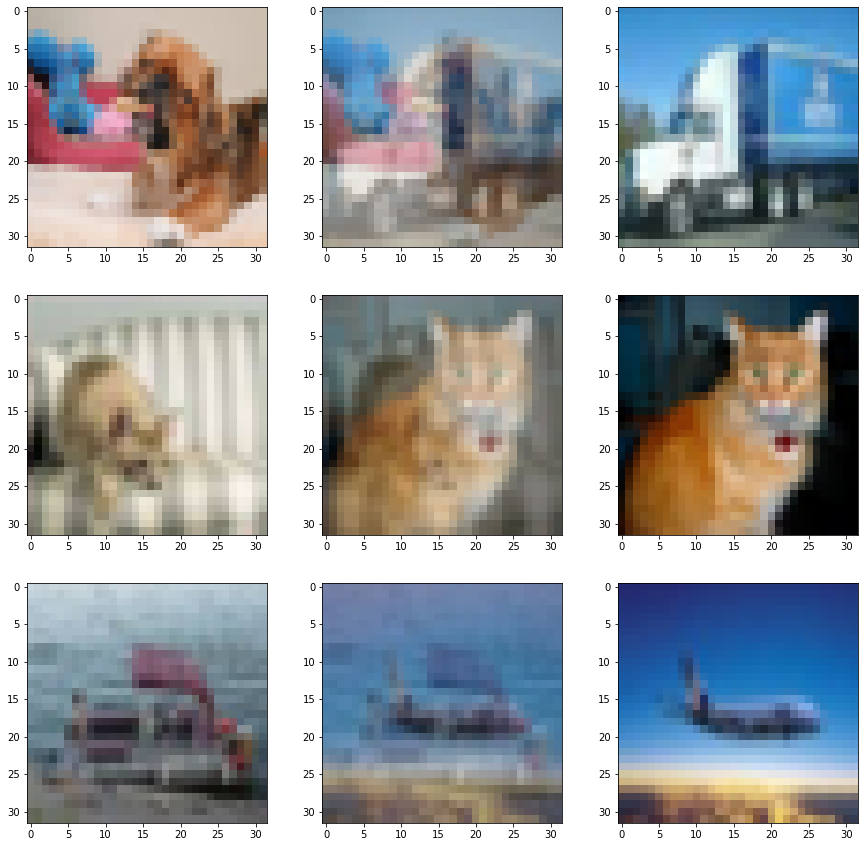

In [81]:
#Displaying a few of the most mixed up images

plt.figure()

f, axarr = plt.subplots(3,3, figsize=(15,15)) 

axarr[0,0].imshow(close_images[0][1][0].cpu().permute(1,2,0))
axarr[0,1].imshow(close_images[0][0].cpu().permute(1,2,0))
axarr[0,2].imshow(close_images[0][1][1].cpu().permute(1,2,0))
axarr[1,0].imshow(close_images[10][1][0].cpu().permute(1,2,0))
axarr[1,1].imshow(close_images[10][0].cpu().permute(1,2,0))
axarr[1,2].imshow(close_images[10][1][1].cpu().permute(1,2,0))
axarr[2,0].imshow(close_images[20][1][0].cpu().permute(1,2,0))
axarr[2,1].imshow(close_images[20][0].cpu().permute(1,2,0))
axarr[2,2].imshow(close_images[20][1][1].cpu().permute(1,2,0))
plt.show()

In the above figure, for each row, the left and right images are the original images used to do mixup.  The center images are the result of a 50/50 mix of the images on either side.  It is striking how the mixture of the truck and plane at the bottom is unidentifiable.  The mixture of the dog and the truck at the top is a little less confusing, as you can still make out the truck.  In the center image, the cats of both original images are still visible.  So, why would we want to put such unidentifiable images into a network?  The authors of the paper state that the purpose is to teach the network that a linear combination of images should be associated with a linear combination of labels.  But is this a correct assumption to make about the property of images?  Is the bottom center image a combination of a truck and a plane?  I would say no, since it looks like neither.  I think a better way to understand mixup is to look at how it teaches the network to deal with difficult examples.  In many networks, overfitting ocurrs when the network begins to "memorize" difficult examples.  Mixup mitigates this in two ways.  First, the network never sees the same image twice, as they are re-mixed with each epoch.  Second, when the network sees one of the center images, it must assign it to a class.  But, no matter what assignment the network makes, it will always be penalized, as the loss is computed using both original labels.  Therefore, the network is always wrong, and being wrong is a pretty good incentive for not memorizing the training data.

In this part of my report, I looked at how the Gaussian and mixup vicinal distributions affect images, and I discussed some of the theoretical notions underlying each.  In the next part, I analyze how these distributions work inside a Resnet.